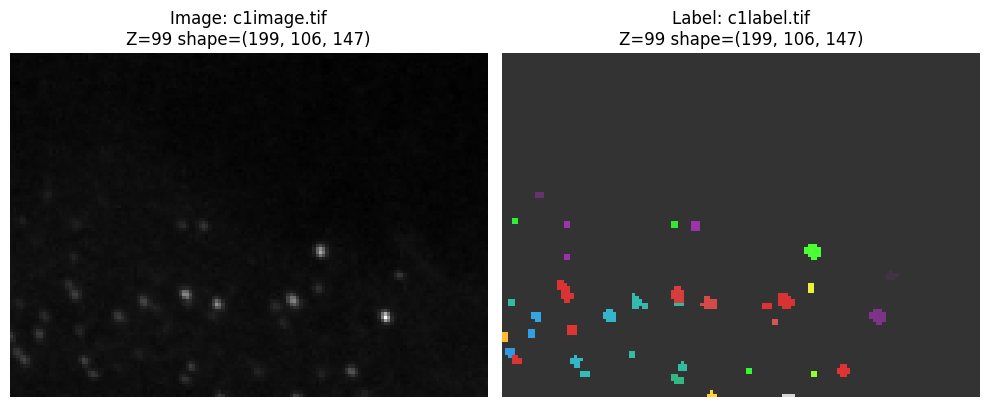

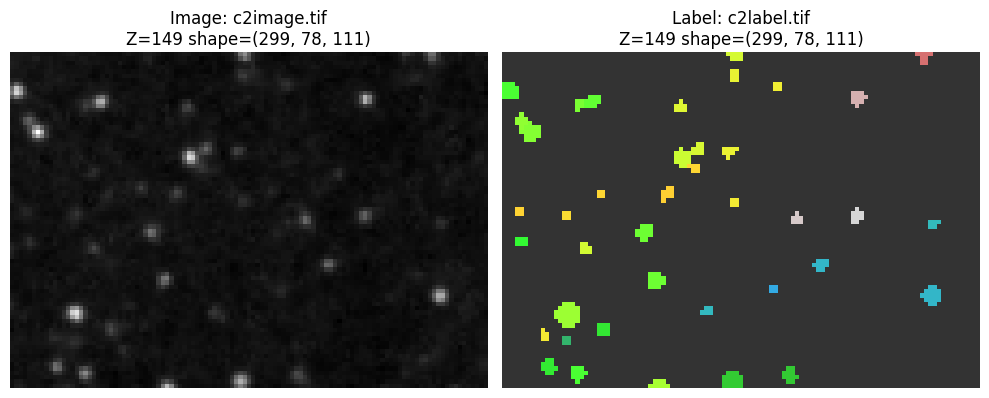

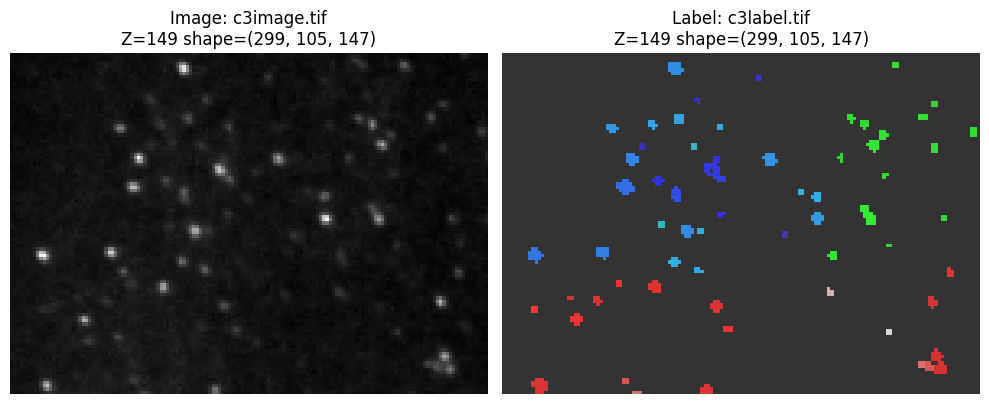

In [1]:
import os
from pathlib import Path
import tifffile
import numpy as np
import matplotlib.pyplot as plt

# Directory containing the dataset (edit as needed)
base_dir = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared")
images_dir = base_dir / "images"
labels_dir = base_dir / "labels"

# List of image files (sort for consistency)
image_files = sorted(images_dir.glob("*.tif"))
label_files = sorted(labels_dir.glob("*.tif"))

# Visualize each image-label pair (max 3 pairs for brevity)
for img_f, lbl_f in zip(image_files[:3], label_files[:3]):
    img = tifffile.imread(img_f)
    lbl = tifffile.imread(lbl_f)

    mid_slice = img.shape[0] // 2  # Show central Z slice

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img[mid_slice], cmap='gray')
    axs[0].set_title(f"Image: {img_f.name}\nZ={mid_slice} shape={img.shape}")
    axs[1].imshow(lbl[mid_slice], cmap='nipy_spectral', alpha=0.8)
    axs[1].set_title(f"Label: {lbl_f.name}\nZ={mid_slice} shape={lbl.shape}")
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()


In [32]:
from pathlib import Path
import pandas as pd

# Path from test_inference_swin_unetr.yaml:
# datasets.hypercubes_dataframe_path:
#   ${paths.data_path}/tests/databases/prepared_1_128_128_128_2_hypercube_view.csv
roi_csv = Path(
    "/clusterfs/nvme/segment_3d/tests/databases/"
    "prepared_1_128_128_128_2_hypercube_view_rois.csv"
)

df = pd.read_csv(roi_csv)

# Apply the same renaming logic as Inferencer._get_data_tiles_metadata
cols_rename = [
    "tile_z_start", "tile_y_start", "tile_x_start",
    "tile_z_end", "tile_y_end", "tile_x_end",
    "tile_channel_size", "tile_time_size",
]
if set(cols_rename).issubset(df.columns):
    df = df.rename(
        columns={
            "prepared_id": "id",
            "tile_z_end": "z_end",
            "tile_y_end": "y_end",
            "tile_x_end": "x_end",
            "tile_z_start": "z_start",
            "tile_y_start": "y_start",
            "tile_x_start": "x_start",
            "tile_time_size": "time_size",
            "tile_channel_size": "channel_size",
        }
    )

volume_rows = df[(df["z_start"] != df["z_end"])]
volume_ids = volume_rows["id"].unique()
# volume_rows = df[(df["z_start"] != df["z_end"]) & (df["id"] > 300)]

# rows = df[(df["id"] ==319)]
print(volume_rows[["id", "z_start", "z_end", "y_start", "y_end", "x_start", "x_end"]].sort_values(by="id"))


      id  z_start  z_end  y_start  y_end  x_start  x_end
50    17       25    153       61    445       19   2835
51    18       25    153       61    445       19   2835
52    19       25    153       61    445       19   2835
53    20       25    153       61    445       19   2835
54    21       25    153       61    445       19   2835
..   ...      ...    ...      ...    ...      ...    ...
171  370       25    153       61    445        7   2567
172  371       25    153       61    445        7   2567
173  372       25    153       61    445        7   3335
174  373       25    153       61    445        7   3335
177  374       25    153       61    445        7   3335

[185 rows x 7 columns]


{np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(31),
 np.int64(32),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(36),
 np.int64(37),
 np.int64(38),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(42),
 np.int64(43),
 np.int64(45),
 np.int64(46),
 np.int64(47),
 np.int64(48),
 np.int64(49),
 np.int64(50),
 np.int64(51),
 np.int64(52),
 np.int64(53),
 np.int64(54),
 np.int64(55),
 np.int64(56),
 np.int64(58),
 np.int64(59),
 np.int64(60),
 np.int64(61),
 np.int64(62),
 np.int64(63),
 np.int64(64),
 np.int64(65),
 np.int64(66),
 np.int64(67),
 np.int64(68),
 np.int64(69),
 np.int64(72),
 np.int64(73),
 np.int64(74),
 np.int64(75),
 np.int64(76),
 np.int64(77),
 np.int64(78),
 np.int64(79),
 np.int64(80),
 np.int64(81),
 np.int64(82),
 np.int64(83),
 np.int64(84),
 np.int64(85),
 np.int64(86),
 np.int64(

In [43]:
from pathlib import Path
import pandas as pd
from collections import defaultdict

base = Path("/clusterfs/nvme/segment_3d/tests/databases")
hypercube_csv = base / "prepared_1_128_128_128_2_hypercube_view.csv"

# Print the columns of the CSV
sample = pd.read_csv(hypercube_csv, nrows=0)
print("Columns:", list(sample.columns))


roi_ids = set(volume_ids.tolist())

tiles_by_roi: dict[int, set[str]] = defaultdict(set)

chunksize = 1_000_000  # adjust as needed
usecols = ["prepared_id", "tile_name", "exists", "is_synthetic"]

out = []
for chunk in pd.read_csv(hypercube_csv, chunksize=chunksize, usecols=usecols):
    # Filter by ROI first to keep memory small
    sub = chunk[chunk["prepared_id"].isin(roi_ids)]
    out.append(sub.to_dict(orient="records"))


Columns: ['first_pc_id', 'prepared_id', 'time_start', 'x_start', 'y_start', 'z_start', 'time_size', 'pc_metadata_json', 'channel_size', 'cube_size', 'tile_name', 'channel_targets', 'occupancy_ratios_ch_0', 'occupancy_ratios_ch_1', 'server_folder', 'output_folder', 'p_metadata_json', 'exists', 'exists_prfs', 'exists_aws', 'exists_oak', 'metadata_tile_json', 'json_excite_map_total', 'unique_targets', 'imaged_locations', 'date_crossed', 'hpf', 'is_synthetic']


Exception ignored in: <function tqdm.__del__ at 0x7f44451f47c0>
Traceback (most recent call last):
  File "/clusterfs/nvme/martinalvarez/miniforge3/envs/segproj/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/clusterfs/nvme/martinalvarez/miniforge3/envs/segproj/lib/python3.12/site-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7f44451f47c0>
Traceback (most recent call last):
  File "/clusterfs/nvme/martinalvarez/miniforge3/envs/segproj/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/clusterfs/nvme/martinalvarez/miniforge3/envs/segproj/lib/python3.12/site-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute '

In [50]:
dfs = []
for d in out:
    df_d = pd.DataFrame.from_records(d)
    dfs.append(df_d)
df_out = pd.concat(dfs)

In [51]:
print(df_out.head())

   prepared_id            tile_name  exists  is_synthetic
0           17  000x_000y_000z.zarr       1             0
1           17  000x_000y_000z.zarr       1             0
2           17  000x_000y_000z.zarr       1             0
3           17  000x_000y_000z.zarr       1             0
4           17  000x_000y_000z.zarr       1             0


In [ ]:
df_out[df_out["exists"].astype(bool) & df_out["is_synthetic"].astype(bool)].value_counts()

prepared_id  tile_name            exists  is_synthetic
165          000x_000y_000z.zarr  1       1               208
166          000x_000y_000z.zarr  1       1               208
Name: count, dtype: int64

: 

In [27]:
# Print the columns of the CSV
sample = pd.read_csv(hypercube_csv, nrows=0)
print("Columns:", list(sample.columns))



Columns: ['first_pc_id', 'prepared_id', 'time_start', 'x_start', 'y_start', 'z_start', 'time_size', 'pc_metadata_json', 'channel_size', 'cube_size', 'tile_name', 'channel_targets', 'occupancy_ratios_ch_0', 'occupancy_ratios_ch_1', 'server_folder', 'output_folder', 'p_metadata_json', 'exists', 'exists_prfs', 'exists_aws', 'exists_oak', 'metadata_tile_json', 'json_excite_map_total', 'unique_targets', 'imaged_locations', 'date_crossed', 'hpf', 'is_synthetic']


In [40]:
set(volume_ids.tolist())

{17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 165,
 166,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,

In [2]:
import pandas as pd
csv = "/clusterfs/vast/forsynthetic/benchmark_tests/data/synthetic_data_iteration_1/supabase_csvs/prepared_cubes.csv"
pd.read_csv(csv, nrows=10)

,id,prepared_id,tile_name,chunk,time,z_start,y_start,x_start,channel,metadata_json,channel_target,occupancy_ratio
0,0,0,000x_000y_000z.zarr,0,0,0,0,0,0,"{""histogram"": {""0.0"": 61, ""1.0"": 87, ""2.0"": 90...",membrane,0.997234
1,1,0,000x_000y_000z.zarr,0,0,0,0,0,1,"{""mask_bbox_dict"": {}}",masks,NaN
2,2,0,000x_000y_000z.zarr,1,0,0,0,128,0,"{""histogram"": {""0.0"": 70, ""1.0"": 112, ""2.0"": 1...",membrane,0.999705
3,3,0,000x_000y_000z.zarr,1,0,0,0,128,1,"{""mask_bbox_dict"": {}}",masks,NaN
4,4,0,000x_000y_000z.zarr,2,0,0,0,256,0,"{""histogram"": {""0.0"": 123, ""1.0"": 213, ""2.0"": ...",membrane,1.000000
5,5,0,000x_000y_000z.zarr,2,0,0,0,256,1,"{""mask_bbox_dict"": {}}",masks,NaN
6,6,0,000x_000y_000z.zarr,3,0,0,0,384,0,"{""histogram"": {""0.0"": 133, ""1.0"": 247, ""2.0"": ...",membrane,1.000000
7,7,0,000x_000y_000z.zarr,3,0,0,0,384,1,"{""mask_bbox_dict"": {""25"": [51, 68, 112, 91, 12...",masks,NaN
8,8,0,000x_000y_000z.zarr,4,0,0,0,512,0,"{""histogram"": {""0.0"": 174, ""1.0"": 363, ""2.0"": ...",membrane,1.000000
9,9,0,000x_000y_000z.zarr,4,0,0,0,512,1,"{""mask_bbox_dict"": {""21"": [0, 116, 85, 33, 128...",masks,NaN


In [18]:
import pandas as pd
csv = "/clusterfs/vast/forsynthetic/benchmark_tests/data/synthetic_data_iteration_1/supabase_csvs/prepared.csv"
pd.read_csv(csv, nrows=10)

,id,created_at,elapsed_sec,software_version,output_folder,metadata_json,acquisition_id,exists,cube_size,server_folder,...,z_end,y_end,x_end,time_size,channel_size,data_location,exists_prfs,exists_aws,exists_oak,is_synthetic
0,0,NaN,NaN,PyPetaKit5D 1.4.6,20250131_mem_histone/fish1_24hpf_mYH/roi2_mb,NaN,NaN,True,128,/clusterfs/vast/forsynthetic/benchmark_tests/d...,...,169,896,1586,1,2,/clusterfs/nvme2/Data/20240911_Korra_Foundatio...,False,False,False,True
1,1,NaN,NaN,PyPetaKit5D 1.4.6,20250131_mem_histone/fish1_24hpf_mYH/roi3_mb,NaN,NaN,True,128,/clusterfs/vast/forsynthetic/benchmark_tests/d...,...,169,896,1586,1,2,/clusterfs/nvme2/Data/20240911_Korra_Foundatio...,False,False,False,True
2,2,NaN,NaN,PyPetaKit5D 1.4.6,20250131_mem_histone/fish1_24hpf_mYH/roi4_arc,NaN,NaN,True,128,/clusterfs/vast/forsynthetic/benchmark_tests/d...,...,54,896,1441,1,2,/clusterfs/nvme2/Data/20240911_Korra_Foundatio...,False,False,False,True
3,3,NaN,NaN,PyPetaKit5D 1.4.6,20250131_mem_histone/fish1_24hpf_mYH/roi5_arc,NaN,NaN,True,128,/clusterfs/vast/forsynthetic/benchmark_tests/d...,...,54,896,1441,1,2,/clusterfs/nvme2/Data/20240911_Korra_Foundatio...,False,False,False,True
4,4,NaN,NaN,PyPetaKit5D 1.4.6,20250131_mem_histone/fish2_24hpf_mChilada/roi1...,NaN,NaN,True,128,/clusterfs/vast/forsynthetic/benchmark_tests/d...,...,54,896,1441,1,2,/clusterfs/nvme2/Data/20240911_Korra_Foundatio...,False,False,False,True
5,5,NaN,NaN,PyPetaKit5D 1.4.6,20250131_mem_histone/fish2_24hpf_mChilada/roi2...,NaN,NaN,True,128,/clusterfs/vast/forsynthetic/benchmark_tests/d...,...,54,896,1441,1,2,/clusterfs/nvme2/Data/20240911_Korra_Foundatio...,False,False,False,True
6,6,NaN,NaN,PyPetaKit5D 1.4.6,20250131_mem_histone/fish2_24hpf_mChilada/roi3...,NaN,NaN,True,128,/clusterfs/vast/forsynthetic/benchmark_tests/d...,...,54,896,1441,1,2,/clusterfs/nvme2/Data/20240911_Korra_Foundatio...,False,False,False,True
7,7,NaN,NaN,PyPetaKit5D 1.4.6,20250204_mem_histone/fish2_24hpf_mYH/roi1,NaN,NaN,True,128,/clusterfs/vast/forsynthetic/benchmark_tests/d...,...,54,896,1441,1,2,/clusterfs/nvme2/Data/20240911_Korra_Foundatio...,False,False,False,True
8,8,NaN,NaN,PyPetaKit5D 1.4.6,20250211_mem_histone/fish2_24hpf_mYH/roi1,NaN,NaN,True,128,/clusterfs/vast/forsynthetic/benchmark_tests/d...,...,28,384,2703,1,2,/clusterfs/nvme2/Data/20240911_Korra_Foundatio...,False,False,False,True
9,9,NaN,NaN,PyPetaKit5D 1.4.6,20250211_mem_histone/fish4_24hpf_mYH/roi4_test,NaN,NaN,True,128,/clusterfs/vast/forsynthetic/benchmark_tests/d...,...,28,384,2714,1,2,/clusterfs/nvme2/Data/20240911_Korra_Foundatio...,False,False,False,True


In [13]:
import pandas as pd
csv = "/clusterfs/nvme/segment_4d/databases/prepared_tile_view_w_annotations_fixed.csv"
df_meta = pd.read_csv(csv, nrows=10)


In [14]:
df_meta.iloc[:, 2:20]

,prepared_id,tile_name,x_start,y_start,z_start,time_start,channel_size,z_size,y_size,x_size,time_size,server_folder,output_folder,hpf,exists,exists_prfs,exists_aws,is_synthetic
0,165,000x_000y_000z.zarr,0,0,0,0,2,128,1024,1664,1,/clusterfs/vast/forsynthetic/benchmark_tests/d...,20250131_mem_histone/fish1_24hpf_mYH/roi2_mb,NaN,True,True,True,True
1,166,000x_000y_000z.zarr,0,0,0,0,2,128,1024,1664,1,/clusterfs/vast/forsynthetic/benchmark_tests/d...,20250131_mem_histone/fish1_24hpf_mYH/roi3_mb,NaN,True,True,True,True
2,167,000x_000y_000z.zarr,0,0,0,0,2,128,1024,1536,1,/clusterfs/vast/forsynthetic/benchmark_tests/d...,20250131_mem_histone/fish1_24hpf_mYH/roi4_arc,NaN,True,True,True,True
3,168,000x_000y_000z.zarr,0,0,0,0,2,128,1024,1536,1,/clusterfs/vast/forsynthetic/benchmark_tests/d...,20250131_mem_histone/fish1_24hpf_mYH/roi5_arc,NaN,True,True,True,True
4,169,000x_000y_000z.zarr,0,0,0,0,2,128,1024,1536,1,/clusterfs/vast/forsynthetic/benchmark_tests/d...,20250131_mem_histone/fish2_24hpf_mChilada/roi1...,NaN,True,True,True,True
5,170,000x_000y_000z.zarr,0,0,0,0,2,128,1024,1536,1,/clusterfs/vast/forsynthetic/benchmark_tests/d...,20250131_mem_histone/fish2_24hpf_mChilada/roi2...,NaN,True,True,True,True
6,171,000x_000y_000z.zarr,0,0,0,0,2,128,1024,1536,1,/clusterfs/vast/forsynthetic/benchmark_tests/d...,20250131_mem_histone/fish2_24hpf_mChilada/roi3...,NaN,True,True,True,True
7,172,000x_000y_000z.zarr,0,0,0,0,2,128,1024,1536,1,/clusterfs/vast/forsynthetic/benchmark_tests/d...,20250204_mem_histone/fish2_24hpf_mYH/roi1,NaN,True,True,True,True
8,173,000x_000y_000z.zarr,0,0,0,0,2,128,512,2816,1,/clusterfs/vast/forsynthetic/benchmark_tests/d...,20250211_mem_histone/fish2_24hpf_mYH/roi1,NaN,True,True,True,True
9,173,000x_001y_000z.zarr,0,0,0,0,2,128,512,2816,1,/clusterfs/vast/forsynthetic/benchmark_tests/d...,20250211_mem_histone/fish2_24hpf_mYH/roi1,NaN,True,True,True,True


In [15]:
df_meta.iloc[:, 20:]

,tile_z_start,tile_y_start,tile_x_start,tile_z_end,tile_y_end,tile_x_end,tile_time_size,tile_channel_size,pc_metadata_json,mask_bbox_dict
0,41,0,50,169,896,1586,1,2,"{""0"":{""histogram"":{""70.0"":113,""100.0"":154,""50....","{""681"":{""zmin"":0,""ymin"":992,""xmin"":27,""zmax"":4..."
1,41,0,50,169,896,1586,1,2,"{""0"":{""histogram"":{""70.0"":113,""100.0"":155,""50....","{""623"":{""zmin"":120,""ymin"":469,""xmin"":249,""zmax..."
2,54,0,33,54,896,1441,1,2,"{""0"":{""histogram"":{""70.0"":127,""100.0"":415,""50....","{""25"":{""zmin"":47,""ymin"":120,""xmin"":230,""zmax"":..."
3,54,0,33,54,896,1441,1,2,"{""0"":{""histogram"":{""70.0"":125,""100.0"":402,""50....","{""259"":{""zmin"":66,""ymin"":0,""xmin"":219,""zmax"":1..."
4,54,0,33,54,896,1441,1,2,"{""0"":{""histogram"":{""70.0"":143,""100.0"":716,""50....","{""12"":{""zmin"":0,""ymin"":0,""xmin"":184,""zmax"":128..."
5,54,0,33,54,896,1441,1,2,"{""0"":{""histogram"":{""70.0"":127,""100.0"":493,""50....","{""171"":{""zmin"":0,""ymin"":381,""xmin"":248,""zmax"":..."
6,54,0,33,54,896,1441,1,2,"{""0"":{""histogram"":{""70.0"":144,""100.0"":739,""50....","{""14"":{""zmin"":0,""ymin"":0,""xmin"":185,""zmax"":128..."
7,54,0,33,54,896,1441,1,2,"{""0"":{""histogram"":{""70.0"":131,""100.0"":471,""50....","{""310"":{""zmin"":0,""ymin"":0,""xmin"":194,""zmax"":12..."
8,28,0,15,28,384,2703,1,2,"{""0"":{""histogram"":{""70.0"":117,""100.0"":199,""50....","{""123"":{""zmin"":0,""ymin"":177,""xmin"":636,""zmax"":..."
9,28,0,15,28,384,2703,1,2,"{""0"":{""histogram"":{""70.0"":116,""100.0"":185,""50....","{""46"":{""zmin"":37,""ymin"":0,""xmin"":622,""zmax"":12..."


In [17]:
df_meta["server_folder"][0]

'/clusterfs/vast/forsynthetic/benchmark_tests/data/synthetic_data_iteration_1/'

In [21]:
pd.read_csv("/clusterfs/nvme/segment_3d/databases/synthetic_data/raw_csv/prepared_tile_view_w_annotations_fixed.csv", nrows=10).columns


Index(['Unnamed: 0.1', 'Unnamed: 0', 'prepared_id', 'tile_name', 'x_start',
       'y_start', 'z_start', 'time_start', 'channel_size', 'z_size', 'y_size',
       'x_size', 'time_size', 'server_folder', 'output_folder', 'hpf',
       'exists', 'exists_prfs', 'exists_aws', 'is_synthetic', 'tile_z_start',
       'tile_y_start', 'tile_x_start', 'tile_z_end', 'tile_y_end',
       'tile_x_end', 'tile_time_size', 'tile_channel_size', 'pc_metadata_json',
       'mask_bbox_dict'],
      dtype='object')

In [18]:
import pandas as pd
csv = "/clusterfs/nvme/segment_3d/databases/synthetic_data/training_metadata.csv"
df_meta_total = pd.read_csv(csv)
df_meta_total.head()

,prepared_id,z_start,y_start,x_start,z_end,y_end,x_end,z_size,y_size,x_size,time_size,channel_size,cube_size,is_synthetic,synthetic_path,real_path
0,165,41,0,50,169,896,1586,128,1024,1664,1,2,NaN,True,/clusterfs/vast/forsynthetic/benchmark_tests/d...,/clusterfs/vast/forsynthetic/benchmark_tests/d...
1,166,41,0,50,169,896,1586,128,1024,1664,1,2,NaN,True,/clusterfs/vast/forsynthetic/benchmark_tests/d...,/clusterfs/vast/forsynthetic/benchmark_tests/d...
2,167,54,0,33,54,896,1441,128,1024,1536,1,2,NaN,True,/clusterfs/vast/forsynthetic/benchmark_tests/d...,/clusterfs/vast/forsynthetic/benchmark_tests/d...
3,168,54,0,33,54,896,1441,128,1024,1536,1,2,NaN,True,/clusterfs/vast/forsynthetic/benchmark_tests/d...,/clusterfs/vast/forsynthetic/benchmark_tests/d...
4,169,54,0,33,54,896,1441,128,1024,1536,1,2,NaN,True,/clusterfs/vast/forsynthetic/benchmark_tests/d...,/clusterfs/vast/forsynthetic/benchmark_tests/d...


In [19]:
df_meta_total["z_start"] - df_meta_total["z_end"] == df_meta_total["z_size"]

0       False
1       False
2       False
3       False
4       False
        ...  
2153    False
2154    False
2155    False
2156    False
2157    False
Length: 2158, dtype: bool

In [11]:
import tifffile
huge_tiff = "/clusterfs/vast/forsynthetic/benchmark_tests/data/20250131_mem_histone_fish1_24hpf_mYH_roi2_mb_Scan_Iter_0000_CamA_ch0_CAM1_stack0000_488nm_0000000msec_0344740755msecAbs_000x_000y_000z_0000t.tif"
huge_tiff_size = tifffile.imread(huge_tiff).shape
print(huge_tiff_size)

(339, 1024, 1764)


In [10]:
z_start=41
y_start=0
x_start=50
z_end=169
y_end=896
x_end=1586
z_size=128
y_size=1024
x_size=1664
print(z_end - z_start)
print(y_end - y_start)
print(x_end - x_start)

z_size, y_size, x_size



128
896
1536


(128, 1024, 1664)

In [6]:
import glob

# Pattern based on your bash example
pattern = "/clusterfs/vast/forsynthetic/benchmark_tests/data/*20251010*fish1*24hpf*roi1*000x_001y_000z*.tif"
# Note: glob.glob with recursive=True will search all subdirectories (**)
found_files = glob.glob(pattern, recursive=True)

# Show up to first 3 matches (like 'head -3')
for f in found_files[:3]:
    print(f)


/clusterfs/vast/forsynthetic/benchmark_tests/data/Korra_Foundation_20251010_mem-histone_fish1_24hpf_roi1_Scan_Iter_0000_CamA_ch0_CAM1_stack0000_488nm_0000000msec_0171538473msecAbs_000x_001y_000z_0000t.tif


In [44]:
import matplotlib.pyplot as plt
import tifffile
from skimage.transform import resize
img_name = "Scan_Iter_0000_0000_0000_0000_0000_0000_0000_0000_0000_0000_CamA_ch0_CAM1_stack0000_488nm_0000000msec_0793617967msecAbs_000x_005y_002z_0000t.tif"
real_path = f"/clusterfs/vast/forsynthetic/benchmark_tests/{img_name}"
synth_path = f"/clusterfs/vast/forsynthetic/benchmark_tests/synthetic_tests/synthetic_data_tif/{img_name}"
label_path = f"/clusterfs/vast/forsynthetic/benchmark_tests/synthetic_tests/masks/{img_name}"
xmin, xmax = 239, 1647
ymin, ymax = 0, 512
zmin, zmax = 0, 184


(184, 512, 1408)


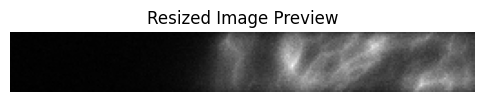

In [45]:
img = tifffile.imread(synth_path)
img = img[zmin:zmax, ymin:ymax, xmin:xmax]
print(img.shape)
# take the middle z slice
# img = img[img.shape[0] // 2]
# take the middle y slice
img = img[:, img.shape[1] // 2]
# Choose a reasonable display size, e.g., 256x256 for 2D, keeping aspect ratio
target_shape = (256, 256)
if img.ndim == 2:
    factor_0 = target_shape[0] / img.shape[0]
    factor_1 = target_shape[1] / img.shape[1]
    target_shape = (
        int(img.shape[0] * min(factor_0, factor_1)),
        int(img.shape[1] * min(factor_0, factor_1))
    )
    img_resized = resize(img, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(img.dtype)
elif img.ndim == 3:
    # For 3D, show the middle slice
    slice_idx = img.shape[0] // 2
    img2d = img[slice_idx]
    factor_0 = target_shape[0] / img2d.shape[0]
    factor_1 = target_shape[1] / img2d.shape[1]
    target_shape = (
        int(img2d.shape[0] * min(factor_0, factor_1)),
        int(img2d.shape[1] * min(factor_0, factor_1))
    )
    img_resized = resize(img2d, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(img2d.dtype)
else:
    img_resized = img  # fallback, no resizing

plt.figure(figsize=(6, 6))
plt.imshow(img_resized, cmap='gray')
plt.title("Resized Image Preview")
plt.axis('off')
plt.show()


(184, 512, 1408)


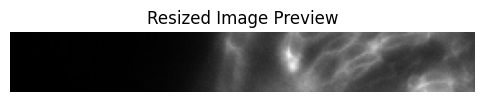

In [46]:
img = tifffile.imread(real_path)
img = img[zmin:zmax, ymin:ymax, xmin:xmax]
print(img.shape)
# take the middle slice
# img = img[img.shape[0] // 2]
# take the middle y slice
img = img[:, img.shape[1] // 2]
# Choose a reasonable display size, e.g., 256x256 for 2D, keeping aspect ratio
target_shape = (256, 256)
if img.ndim == 2:
    factor_0 = target_shape[0] / img.shape[0]
    factor_1 = target_shape[1] / img.shape[1]
    target_shape = (
        int(img.shape[0] * min(factor_0, factor_1)),
        int(img.shape[1] * min(factor_0, factor_1))
    )
    img_resized = resize(img, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(img.dtype)
elif img.ndim == 3:
    # For 3D, show the middle slice
    slice_idx = img.shape[0] // 2
    img2d = img[slice_idx]
    factor_0 = target_shape[0] / img2d.shape[0]
    factor_1 = target_shape[1] / img2d.shape[1]
    target_shape = (
        int(img2d.shape[0] * min(factor_0, factor_1)),
        int(img2d.shape[1] * min(factor_0, factor_1))
    )
    img_resized = resize(img2d, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(img2d.dtype)
else:
    img_resized = img  # fallback, no resizing

plt.figure(figsize=(6, 6))
plt.imshow(img_resized, cmap='gray')
plt.title("Resized Image Preview")
plt.axis('off')
plt.show()


(184, 512, 1408)


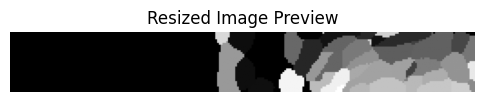

In [47]:
img = tifffile.imread(label_path)
img = img[zmin:zmax, ymin:ymax, xmin:xmax]
print(img.shape)
# take the middle slice
# img = img[img.shape[0] // 2]
# take the middle y slice
img = img[:, img.shape[1] // 2]
# Choose a reasonable display size, e.g., 256x256 for 2D, keeping aspect ratio
target_shape = (256, 256)
if img.ndim == 2:
    factor_0 = target_shape[0] / img.shape[0]
    factor_1 = target_shape[1] / img.shape[1]
    target_shape = (
        int(img.shape[0] * min(factor_0, factor_1)),
        int(img.shape[1] * min(factor_0, factor_1))
    )
    img_resized = resize(img, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(img.dtype)
elif img.ndim == 3:
    # For 3D, show the middle slice
    slice_idx = img.shape[0] // 2
    img2d = img[slice_idx]
    factor_0 = target_shape[0] / img2d.shape[0]
    factor_1 = target_shape[1] / img2d.shape[1]
    target_shape = (
        int(img2d.shape[0] * min(factor_0, factor_1)),
        int(img2d.shape[1] * min(factor_0, factor_1))
    )
    img_resized = resize(img2d, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(img2d.dtype)
else:
    img_resized = img  # fallback, no resizing

plt.figure(figsize=(6, 6))
plt.imshow(img_resized, cmap='gray')
plt.title("Resized Image Preview")
plt.axis('off')
plt.show()


ModuleNotFoundError: No module named 'swincell'